<a href="https://colab.research.google.com/github/BDouchet/BMDATA/blob/main/Multi_Classification_clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Load Data

A sample of data extracted from ImageNet and focusing on the classification of clothes.

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1tkGm17lUiNxdpAJ7OLV_H3hPCbD8JcMw'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data.zip')

with ZipFile('data.zip', 'r') as zip:
   zip.extractall()
   print('Done')


Done


The file is alreday split into three dataset : Train, Validation and Test.

Images are divided in 8 classes : 

*   **Accessories**
*   **jackets**
*   **jeans**
*   **knitwear**
*   **shirts**
*   **shoes**
*   **shorts**
*   **tees** 

An example of the images in the dataset. All the images have a size of 432x300x3.

(432, 300, 3)


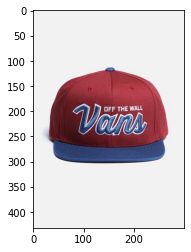

In [ ]:
img=plt.imread("/content/data/train/accessories/productimg_1.jpg")
plt.imshow(img)
print(img.shape)

Reading and processing of the images.
I resize all our images to a size of 266x150x3 (above all to speed up the training phase).
The labels are one-hot encoded, which means they are represented as an of length n (the number of class) with the value 1 on the associated label index and 0 on the others. The images are shuffled.

Datasets sizes : 

*  Train : 3467 
*  Validation : 382 
*  Test : 8

*NB : the test dataset apppears to be really small. However, we only want to explore methods and not to find the best model for this problem.*  





In [ ]:
path="data/"
train_dir = path+"train/"
test_dir = path+"validation/"
from sklearn.utils import shuffle

#{0 : accessories,1 : jackets, 2 : jeans, 3 : knitwear, 4 : shirts, 5 : shoes, 6 : shorts, 7 : tees}

rows=266
columns=150

def read_process(dataset,columns,rows,rand=True):
    labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
    dir=path+dataset+"/"
    X,Y=[],[]
    for j,label in enumerate(labels):
        for file in os.listdir(dir+label+"/"):
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
            y=[0 for _ in range(len(labels))]
            y[j]=1
            Y.append(y)
    if rand : 
        return shuffle(np.array(X),np.array(Y))
    else:
        return np.array(X),np.array(Y)

def read_process_test(columns,rows):
    X_test=[]
    for file in os.listdir("/content/data/test/unknown/"):
        X_test.append(cv2.resize(cv2.imread("/content/data/test/unknown/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
    return np.array(X_test)

X_train,Y_train=read_process("train",columns,rows)
X_val,Y_val=read_process("valid",columns,rows)
X_test=read_process_test(150,266)

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(3467, 266, 150, 3) (3467, 8)
(382, 266, 150, 3) (382, 8)
(8, 266, 150, 3)


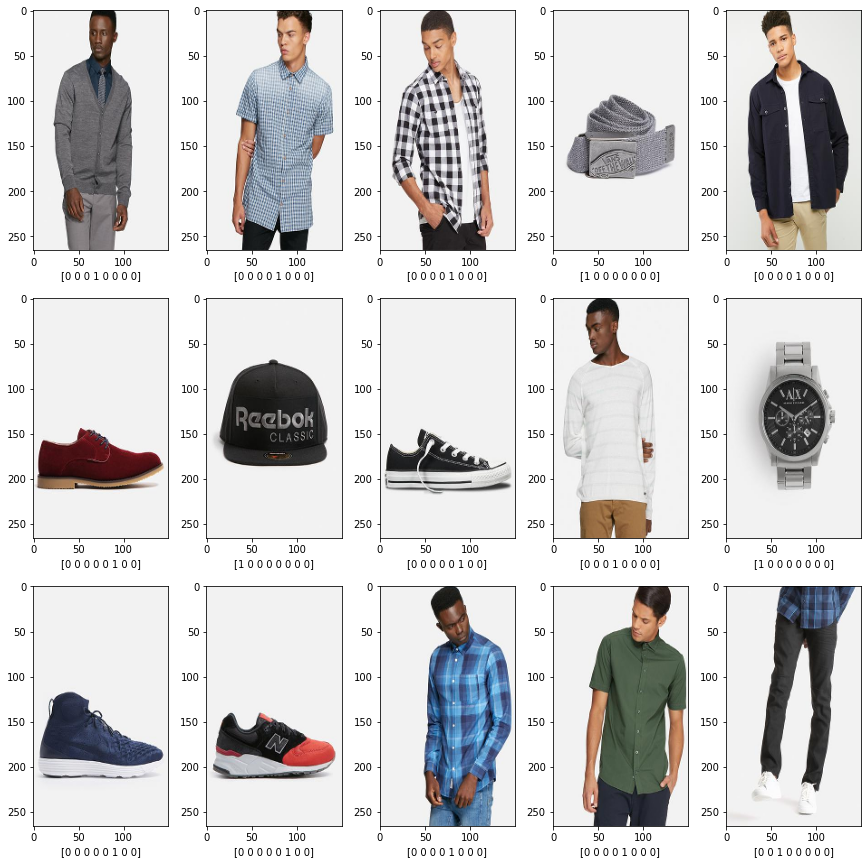

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(str(Y_train[i]))
    plt.sca(ax)
plt.show()



# Create and Train a Model

I create a classical CNN based on the VGG architecture. I reduce the number of parameters : less filters per layers (multiples of 16 instead of 64) and less convolutional layers (12 instead of 19). The last activation function is softmax in order to get a vector of probabilites where the sum of the elements is equal to 1. Intermediary activation functions are ReLU.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 264, 148, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 262, 146, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 131, 73, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 71, 32)       4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 69, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 32, 64)        1

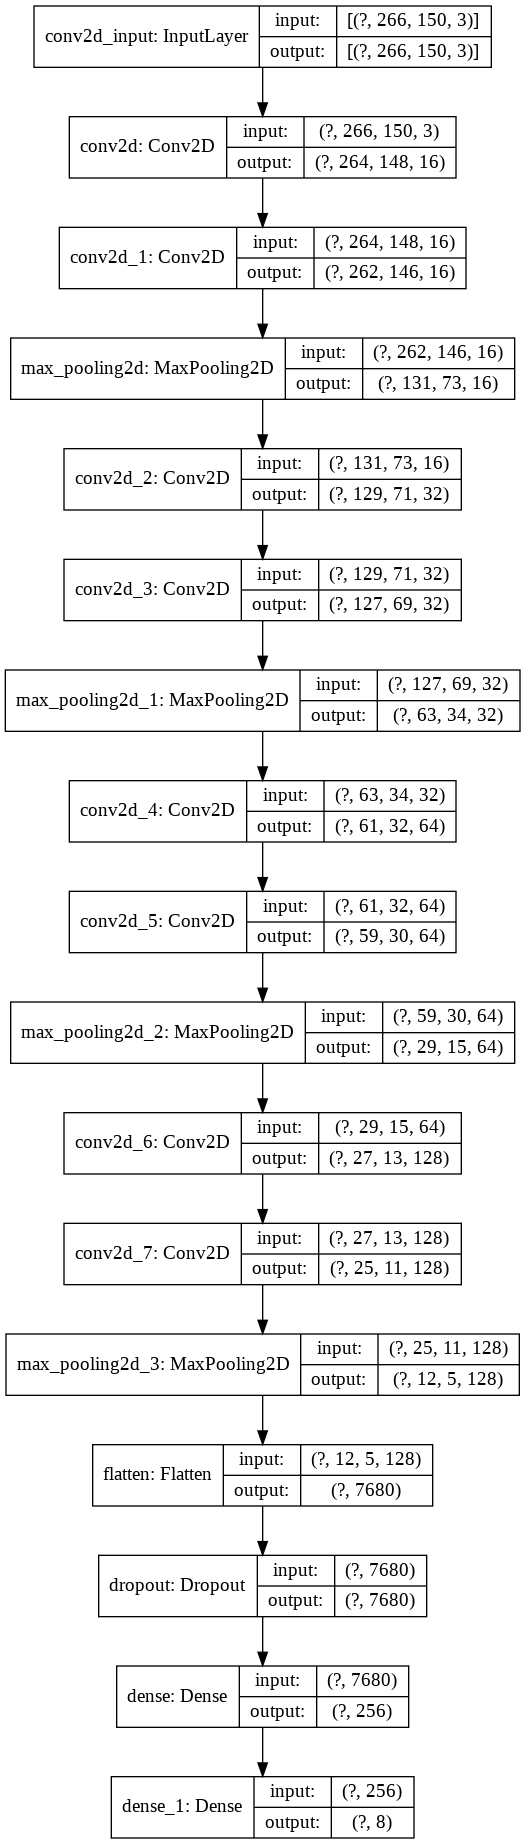

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(266,150, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D()) 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

print(model.summary())
plot_model(model,show_shapes=True)

Training of the built model. Hyperparameters used :


*   epochs = 50
*   Batch_size = 32
*   loss : categorical cross entropy
*   optimizer : Adam with learning rate=0.001
*   Data Augmentation : vertical flip, zoom (0.8<x<1.2), rotation (<20°), vertical & horizontal shift (<0.2) and shear range(<0.2)

Images are scaled to be between 0 and 1.







In [ ]:
ntrain=len(X_train)
nval=len(X_val)
epochs=50
batch_size=32

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001), metrics=['acc'])

#tensorboard = TensorBoard(log_dir="/content/drive/My Drive/Colab Notebooks/BMDATA/TP1/logs/{}".format(NAME))

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   vertical_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

history=model.fit(train_generator, steps_per_epoch=ntrain // batch_size,
                  epochs=epochs,validation_data=val_generator,
                  validation_steps= nval // batch_size)

#model.save("/content/drive/My Drive/Colab Notebooks/BMDATA/TP1/models/"+NAME+".h5")

Epoch 1/50
108/108 [==============================] - 30s 278ms/step - loss: 1.7962 - acc: 0.3709 - val_loss: 1.3104 - val_acc: 0.5653
Epoch 2/50
108/108 [==============================] - 30s 279ms/step - loss: 1.1020 - acc: 0.6105 - val_loss: 1.1041 - val_acc: 0.5227
Epoch 3/50
108/108 [==============================] - 30s 278ms/step - loss: 0.8065 - acc: 0.7028 - val_loss: 0.5701 - val_acc: 0.7699
Epoch 4/50
108/108 [==============================] - 30s 279ms/step - loss: 0.6961 - acc: 0.7409 - val_loss: 0.5091 - val_acc: 0.8097
Epoch 5/50
108/108 [==============================] - 30s 278ms/step - loss: 0.6225 - acc: 0.7674 - val_loss: 0.4180 - val_acc: 0.8466
Epoch 6/50
108/108 [==============================] - 30s 278ms/step - loss: 0.5532 - acc: 0.8000 - val_loss: 0.4300 - val_acc: 0.8438
Epoch 7/50
108/108 [==============================] - 30s 278ms/step - loss: 0.5155 - acc: 0.8017 - val_loss: 0.3799 - val_acc: 0.8864
Epoch 8/50
108/108 [==============================] - 3

I plot the accuracy and loss values through epochs and I observe that my model trained well (no underfitting and no overfitting). The number of parameters is sufficient and explains the data provided.

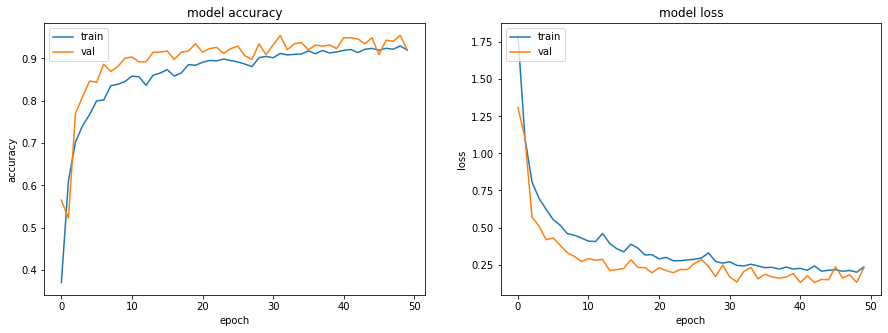

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

Explore test predictions. In the test dataset, a blank image has been inserted to observe how the network reacts.

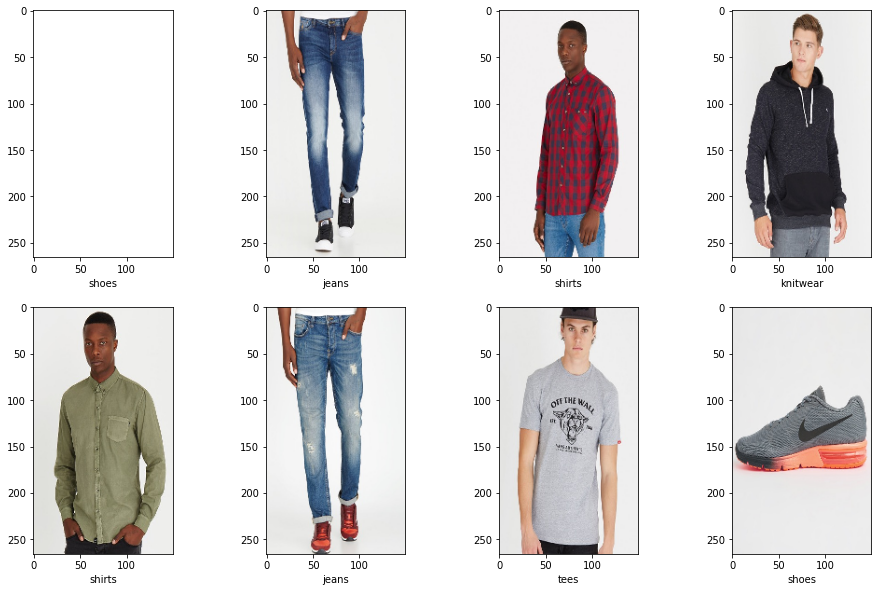

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(150,266)
Y_test=model.predict(X_test/255)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()
    

# Pretrained models

In this part, I use major pretrained model with ImageNet to observes their predictions. The examples below are dedicated to VGG16 but are appliable to other CNN architectures. Their input shape is 224x224 so it is necessary to resize all the images.

In [ ]:

import numpy as np
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet

X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

vgg_model = vgg16.VGG16(weights='imagenet')

#inception_model = inception_v3.InceptionV3(weights='imagenet')

#resnet_model = resnet50.ResNet50(weights='imagenet')

#mobilenet_model = mobilenet.MobileNet(weights='imagenet')


553467904/553467096 [==============================] - 23s 0us/step


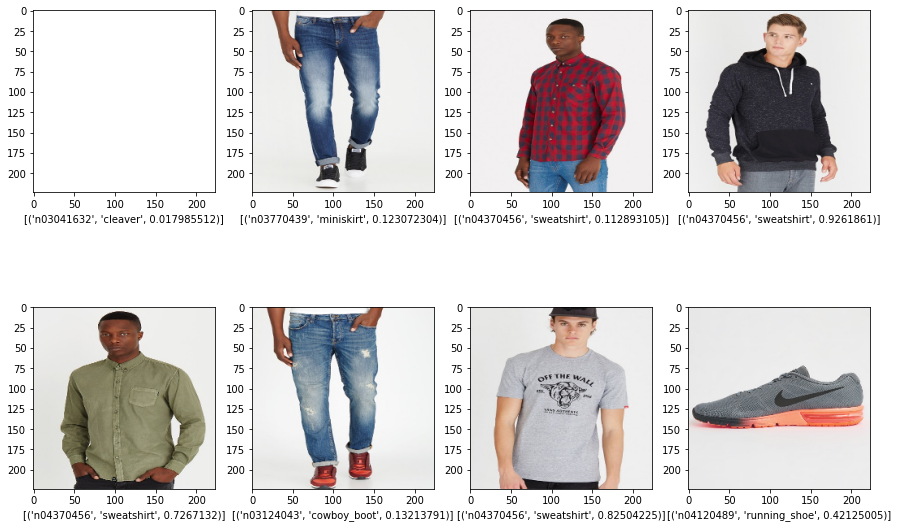

In [ ]:
X_test=read_process_test(224,224)

processed_image = vgg16.preprocess_input(X_test)
predictions = vgg_model.predict(processed_image)

Y_test=vgg16.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()


# Transfer Learning

I use this optimized VGG for ImageNet dataset to predict the classes. Thus, I replace the top of the network (made of the three dense layers) by a classifier made for our data.

The idea is to generate the features from this network and then train a model with the features as an input to predict the class. The first part consists in the calculation and the process of the features.

In [ ]:
from tensorflow.keras.applications import VGG16

batch_size=32

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

nTrain = len(X_train)
nVal = len(X_val)

train_features,val_features = conv_base.predict(X_train),conv_base.predict(X_val)
train_features,val_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)),np.reshape(val_features, (nVal, 7 * 7 * 512))

print(train_features.shape,Y_train.shape)
print(val_features.shape,Y_val.shape)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

So for each image I obtain 512 features of size 7x7. I flatten them and process them through our classifier. As an example I plot some of these intermediary features (9 feature maps of size 28x28)).

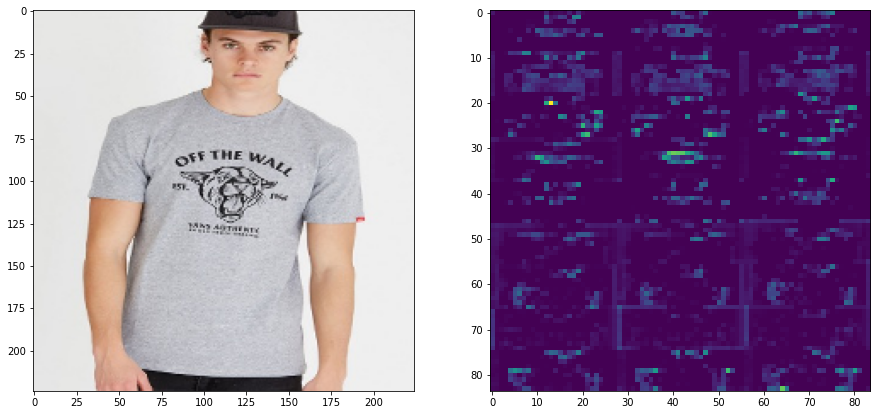

In [ ]:
X_test=read_process_test(224,224)[-1]
conv_base_demo=models.Sequential()
for i in range(11):
    conv_base_demo.add(conv_base.layers[i])
predictions = conv_base_demo.predict(np.array([X_test]))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.imshow(cv2.cvtColor(X_test, cv2.COLOR_BGR2RGB))
output=[]
for i in range(3):
    row=[]
    for j in range(3):
        pred=predictions[0,:,:,3*i+j]
        row.append(pred)
    output.append(row)
ax2.imshow(np.reshape(output,(84,84)))
plt.show()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 6,424,840
Trainable params: 6,424,840
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
109/109 [==============================] - 1s 6ms/step - loss: 5.7019 - acc: 0.8327 - val_loss: 0.5667 - val_acc: 0.9267
Epoch 2/20
109/109 [==============================] - 1s 5ms/step - loss: 0.4682 - acc: 0.8907 - val_loss: 0.2474 - val_acc: 0.9319
Epoch 3/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.9109 - val_los

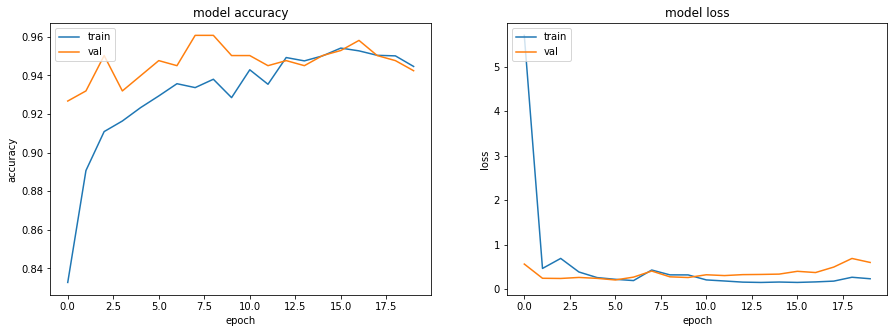

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))
print(model2.summary())

model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['acc'])
history2=model2.fit(train_features,Y_train,validation_data=(val_features,Y_val),batch_size=32,epochs=20)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history2.history['acc'])
ax1.plot(history2.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

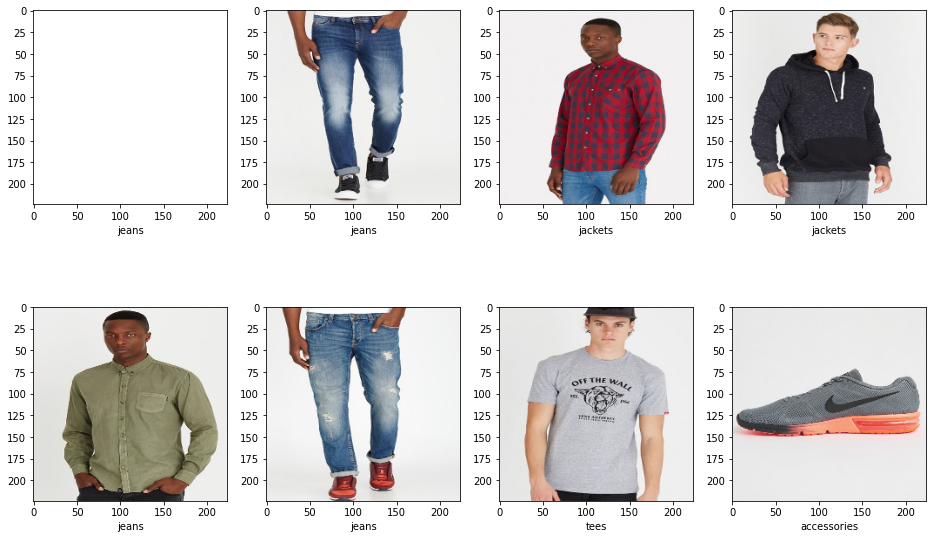

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(224,224)
Y_test=model2.predict(np.reshape(conv_base.predict(X_test/255),(len(X_test),7*7*512)))
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()

# Train more layers in the architecture

I train more layer in the proposed architecture and I will certainly obtain a better accuracy. In this example, I freeze the network except the three last weight layers.

In [ ]:
from tensorflow.keras.applications import VGG16

batch_size=16
epochs=20

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in conv_base.layers[:-4]:
    layer.trainable = False

for layer in conv_base.layers:
    print(layer, layer.trainable)

model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['acc'])

X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

ntrain,nval=len(X_train),len(X_val)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

history3=model3.fit(train_generator, steps_per_epoch=ntrain // batch_size,
          epochs=epochs,validation_data=val_generator,
          validation_steps= nval // batch_size)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdf4a50c5c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a3ad0b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf78086da0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdf4a3ad6d8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a50c470> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a3ad0f0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdf4a3a9320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a3a0c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a3a0208> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdf4a3b76a0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdf4a33f9b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

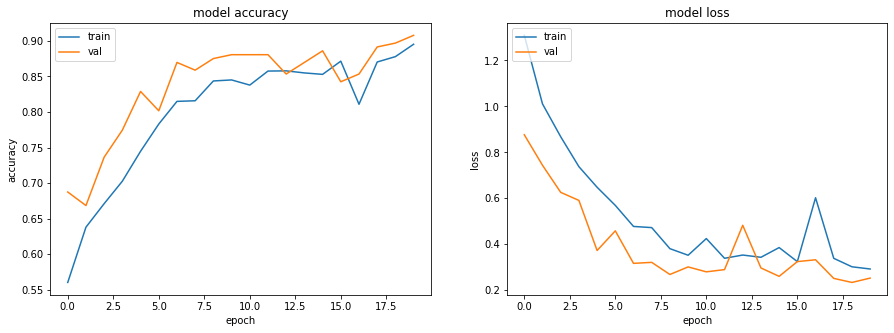

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history3.history['acc'])
ax1.plot(history3.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history3.history['loss'])
ax2.plot(history3.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

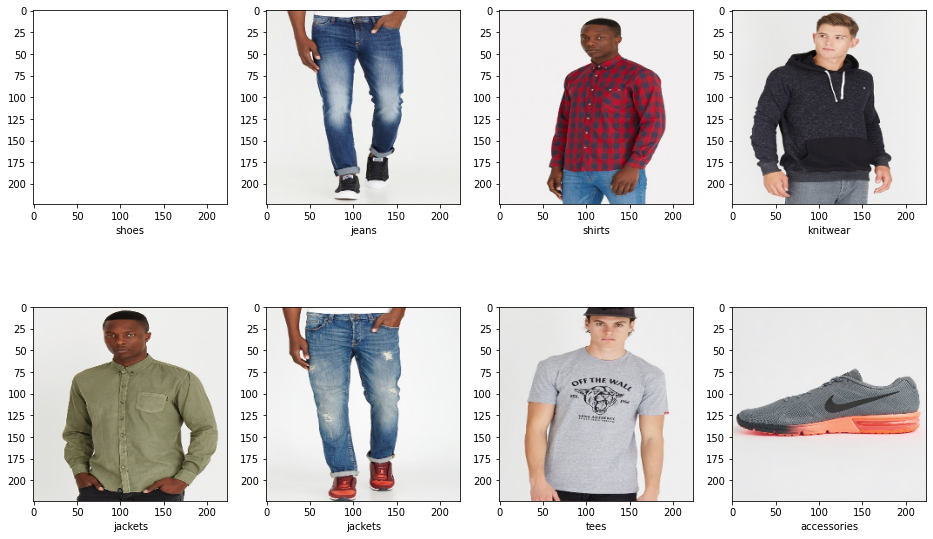

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(224,224)
Y_test=model3.predict(X_test/255)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()

# KNN

This part implement a K Nearest Neighbours alorithm to search the most similar pictures in a pool of pictures. I compare the feature vector of size 7x7x512=25088 from the VGG16.  

In [ ]:
X_test=read_process_test(224,224)

labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X=[]
names=[]
for dataset in ["train","valid"]:
    dir=path+dataset+"/"
    for label in labels:
        for file in os.listdir(dir+label+"/"):
            names.append(dir+label+"/"+file)
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(224,224),interpolation=cv2.INTER_CUBIC))

X=np.array(X)

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

X=np.reshape(conv_base.predict(X),(len(X),7*7*512))
Y_test=np.reshape(conv_base.predict(X_test),(len(X_test),7*7*512))

print(X.shape,Y_test.shape)

(3849, 25088) (8, 25088)


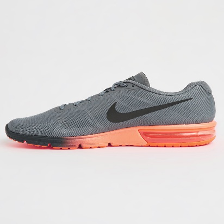

3 Nearest Neighbours :


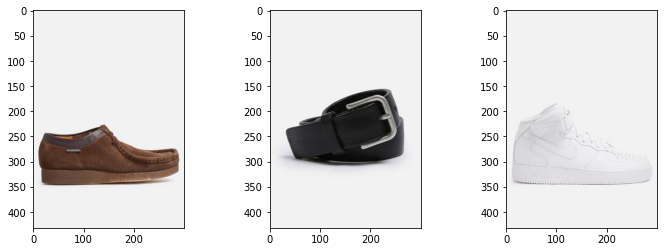


-----------------------------------------



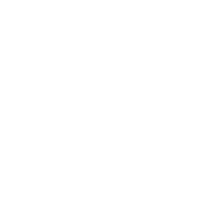

3 Nearest Neighbours :


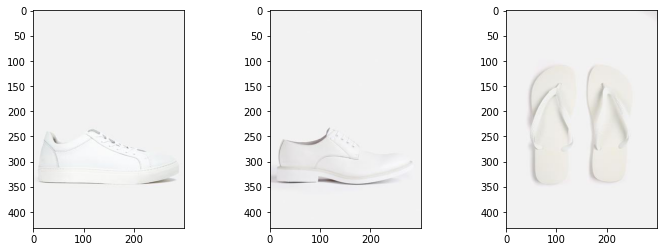


-----------------------------------------



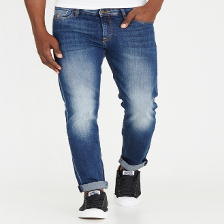

3 Nearest Neighbours :


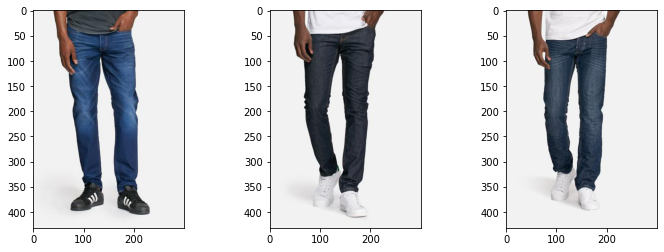


-----------------------------------------



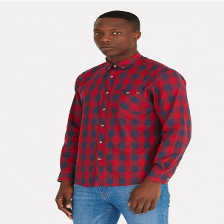

3 Nearest Neighbours :


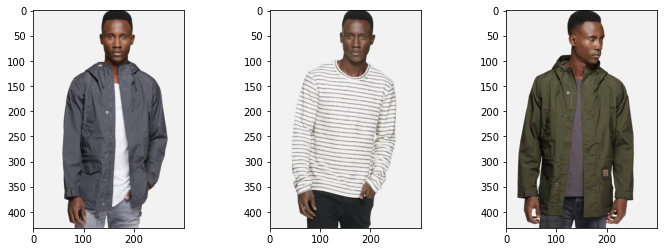


-----------------------------------------



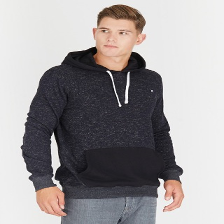

3 Nearest Neighbours :


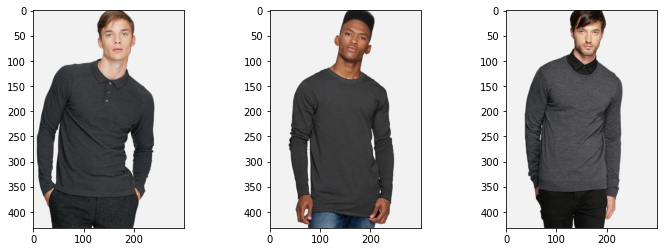


-----------------------------------------



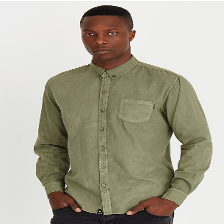

3 Nearest Neighbours :


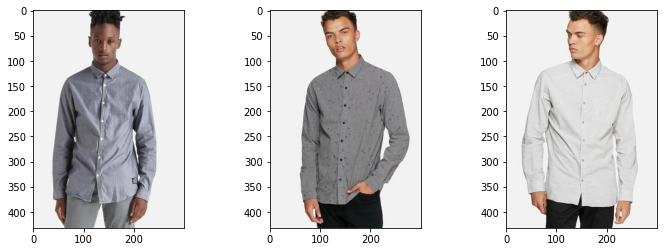


-----------------------------------------



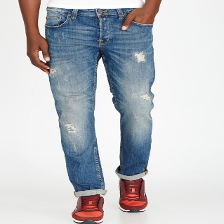

3 Nearest Neighbours :


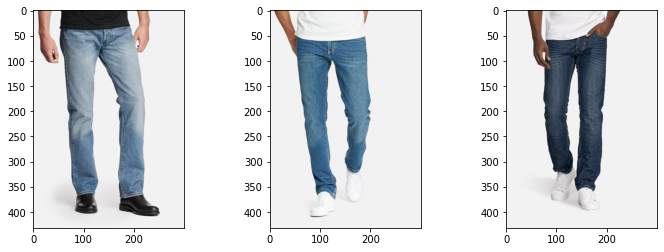


-----------------------------------------



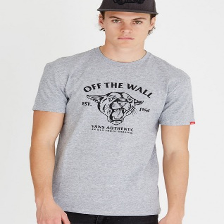

3 Nearest Neighbours :


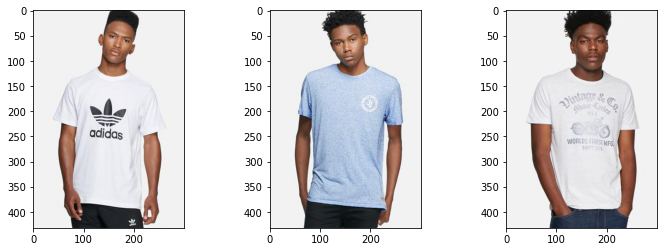


-----------------------------------------



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X,names)
answer=neigh.kneighbors(Y_test, return_distance=False)

for j,img in enumerate(X_test):
    cv2_imshow(img)
    print("3 Nearest Neighbours :")
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    for i, ax in enumerate(axs.flatten()):
        img=plt.imread(names[answer[j,i]])
        plt.imshow(img)
        plt.sca(ax)
    plt.show()
    print("")
    print("-----------------------------------------")
    print("")


# PCA

PCA is a process allowing to project multi-dimensionnal data on the most explainable hyperplane (in many case a plane). The hyperplane is calculated from the n eigenvactors associated to the n highest eigenvalues calculated from the correlation matrix of our data. 

By calculating the explained ratio variance, I estimate the quantity of explained information in this projection.

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X=[]
names=[]
for dataset in ["train","valid"]:
    dir=path+dataset+"/"
    for label in labels:
        for file in os.listdir(dir+label+"/"):
            names.append(dir+label+"/"+file)
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(224,224),interpolation=cv2.INTER_CUBIC))

X=np.array(X)

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

X=np.reshape(conv_base.predict(X),(len(X),7*7*512))

from sklearn.decomposition import PCA
pca = PCA(svd_solver='full',n_components=2)
coord = pca.fit_transform(X)
#print(pca.n_components_)
print("Eigen values :" + str(pca.explained_variance_))
print("Explained Information :" + str(pca.explained_variance_ratio_))


Eigen values :[379199.72 169653.19]
Explained Information :[0.16360392 0.07319606]


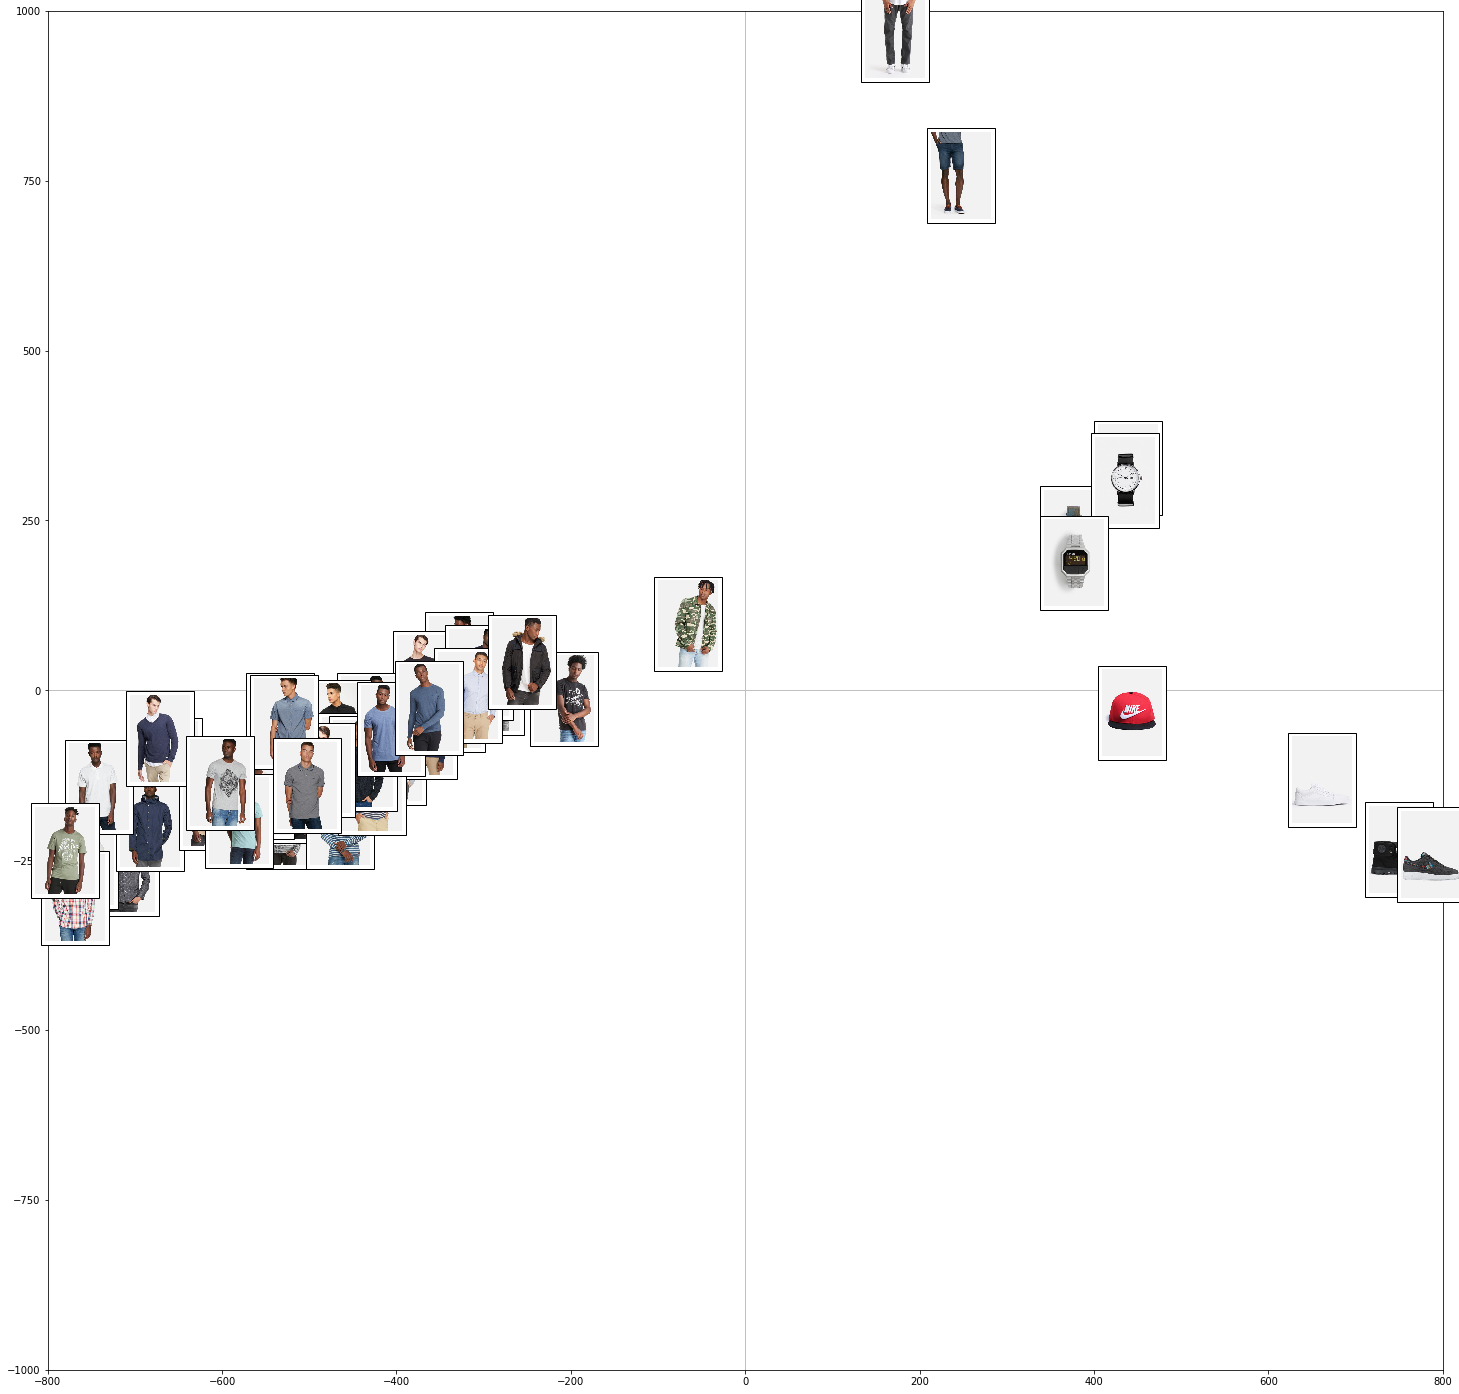

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

n=75
fig, axes = plt.subplots(figsize=(25,25))
axes.set_xlim(-800,800)
axes.set_ylim(-1000,1000)
for _ in range(n):
    i=random.randint(0,3848)
    x=coord[i,0]
    y=coord[i,1]
    img=plt.imread(names[i])
    imagebox = OffsetImage(img, zoom=0.2)
    ab = AnnotationBbox(imagebox, (x,y))
    axes.add_artist(ab)  
    plt.draw()
plt.plot([-1000,1000],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1000,1000],color='silver',linestyle='-',linewidth=1)
plt.show()
